## Data Import

### Import data

In [1]:
# Import modules

import pandas as pd
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
import sklearn.feature_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
import time

In [2]:
# Set parameters

pd.set_option('max_columns', 500)
warnings.filterwarnings('ignore')

rand_seed = 1234
sampling_percentage = 1
up_sampling_coef = 0.1
dn_sampling_coef = 0.8
train_test_split_thresh = 0.9
K_best_thresh = 30

start_time = time.time()

In [3]:
# Import data and select rows and columns
predict_table = pd.read_csv("data/predict_table.csv", header=None) 
predict_table = predict_table.sample(frac = sampling_percentage, replace = False, random_state = rand_seed)
predict_table.rename(columns={0: 'trip_id',
                              1: 'tripduration',
                              2: 'birthyear',
                              3: 'gender',
                              4: 'usertype',
                              5: 'rental_start_time',
                              6: 'from_station_id',
                              7: 'station_city',
                              8: 'station_dpcapacity',
                              9: 'bus_count',
                              10: 'number_of_reads',
                              11: 'speed',
                              12: 'air_temperature',
                              13: 'humidity',
                              14: 'rain_intensity',
                              15: 'total_rain',
                              16: 'wind_speed',
                              17: 'maximum_wind_speed',
                              18: 'solar_radiation'
}, inplace = True);
predict_table = predict_table.drop(columns = ['trip_id'])

## Data Cleaning

### Change data types

In [4]:
# Convert 'object' to 'numeric'

for col_name in predict_table.columns:
    if predict_table[col_name].dtypes == 'object' and col_name != 'usertype' and col_name != 'gender' and col_name != 'rental_start_time' and col_name != 'station_city':
        predict_table[col_name] = pd.to_numeric(predict_table[col_name], errors='coerce')

In [5]:
# Fill in NAs

predict_table['gender'] = predict_table['gender'].replace('NA', np.nan, regex = True)
predict_table['station_dpcapacity'] = predict_table['station_dpcapacity'].replace(0, np.nan, regex = True)

In [6]:
# Set date and time format

predict_table['rental_date'] = [datetime.datetime.strptime(dates, '%m-%d-%Y').date() for dates in predict_table['rental_start_time'].str[:10]]
predict_table['rental_date'] = predict_table['rental_date'].apply(mdates.date2num)

predict_table['rental_time'] = predict_table['rental_start_time'].str[11:]
predict_table = predict_table.drop(columns = ['rental_start_time'])

In [7]:
#Show head

predict_table.head(5)

,tripduration,birthyear,gender,usertype,from_station_id,station_city,station_dpcapacity,bus_count,number_of_reads,speed,air_temperature,humidity,rain_intensity,total_rain,wind_speed,maximum_wind_speed,solar_radiation,rental_date,rental_time
14496005,2648,NaN,NaN,Customer,341,Chicago,39.0,NaN,NaN,NaN,15.0,56.0,0.0,65.0,2.0,3.0,221.0,736821.0,PM
14645033,394,1992.0,Male,Subscriber,133,Chicago,31.0,NaN,NaN,NaN,11.0,91.0,0.0,59.0,2.0,2.0,113.0,736836.0,PM
11379801,802,NaN,NaN,Customer,448,Chicago,15.0,47.0,430.0,20.0,20.0,77.0,0.0,72.0,1.0,2.0,223.0,736501.0,PM
7156661,706,1985.0,Male,Subscriber,20,Chicago,15.0,19.0,160.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,736099.0,PM
4563937,1192,NaN,NaN,Customer,268,Chicago,39.0,NaN,NaN,NaN,18.0,82.0,0.0,278.0,3.0,4.0,356.0,735794.0,PM


### Create 10-day traffic history data

In [8]:
# Import station_id to loop through later

bike_station = predict_table["from_station_id"]
bike_station = bike_station.drop_duplicates()
bike_station = bike_station.sort_values()
bike_station = bike_station.reset_index(drop=True)

In [9]:
# Group by traffic data using 'from_station_id' and 'rental_date'

df = predict_table[['from_station_id', 'rental_date', 'bus_count', 'number_of_reads', 'speed']]
df = df.groupby(['from_station_id', 'rental_date']).mean()
df = df.sort_values(by = ['from_station_id', 'rental_date'], ascending = True)
df = df.reset_index(drop = False)
df.head()

,from_station_id,rental_date,bus_count,number_of_reads,speed
0,2,735726.0,NaN,NaN,NaN
1,2,735727.0,NaN,NaN,NaN
2,2,735728.0,NaN,NaN,NaN
3,2,735729.0,NaN,NaN,NaN
4,2,735730.0,NaN,NaN,NaN


In [10]:
# Generate moving average of bus_count, number_of_reads, speed and append them to traffic table

traffic_table = pd.DataFrame()
for station in bike_station:
    temp = df.loc[df['from_station_id'] == station].copy()
    temp['bus_count_10'] = temp['bus_count'].rolling(window = 10).mean()
    temp['number_of_reads_10'] = temp['number_of_reads'].rolling(window = 10).mean()
    temp['speed_10'] = temp['speed'].rolling(window = 10).mean()
    traffic_table = traffic_table.append(temp, ignore_index = True)
    
traffic_table['traffic_rental_date_history_10'] = traffic_table['rental_date'] + 1
traffic_table = traffic_table[['from_station_id', 'traffic_rental_date_history_10', 'bus_count_10', 'number_of_reads_10', 'speed_10']]
traffic_table.head()

,from_station_id,traffic_rental_date_history_10,bus_count_10,number_of_reads_10,speed_10
0,2,735727.0,NaN,NaN,NaN
1,2,735728.0,NaN,NaN,NaN
2,2,735729.0,NaN,NaN,NaN
3,2,735730.0,NaN,NaN,NaN
4,2,735731.0,NaN,NaN,NaN


### Create 10-day weather history data

In [11]:
# Group by weather data using 'rental_date'

weather_table = predict_table[['rental_date', 'air_temperature', 'humidity', 'rain_intensity', 
                  'total_rain', 'wind_speed', 'maximum_wind_speed', 'solar_radiation']]
weather_table = weather_table.groupby(['rental_date']).mean()
weather_table = weather_table.sort_values(by = ['rental_date'], ascending = True)
weather_table = weather_table.reset_index(drop = False)
weather_table.head()

,rental_date,air_temperature,humidity,rain_intensity,total_rain,wind_speed,maximum_wind_speed,solar_radiation
0,735046.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,735047.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,735048.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,735049.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,735050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Generate moving average of all weather information and append it to weather table

for col_name in weather_table.columns:
    weather_table[col_name + '_10'] = weather_table[col_name].rolling(window = 10).mean()
weather_table['weather_rental_date_history_10'] = weather_table['rental_date'] + 1
weather_table = weather_table[['weather_rental_date_history_10', 'air_temperature_10', 'humidity_10', 
                               'rain_intensity_10', 'total_rain_10', 'wind_speed_10', 
                               'maximum_wind_speed_10', 'solar_radiation_10']]
weather_table.head()

,weather_rental_date_history_10,air_temperature_10,humidity_10,rain_intensity_10,total_rain_10,wind_speed_10,maximum_wind_speed_10,solar_radiation_10
0,735047.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,735048.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,735049.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,735050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,735051.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Join rental/traffic history/weather history tables and obtain station level data

In [13]:
# Join rental/traffic history/rental history tables and select columns

df_joint = pd.merge(predict_table, traffic_table, 
                    left_on = ['from_station_id', 'rental_date'], right_on = ['from_station_id', 'traffic_rental_date_history_10'], 
                    how = 'left')
df_joint = pd.merge(df_joint, weather_table, 
                    left_on = 'rental_date', right_on = 'weather_rental_date_history_10', 
                    how = 'left')
df_joint['counter'] = [1] * df_joint.shape[0]
df_joint = df_joint[['from_station_id', 'rental_date', 'counter',
                     'rental_time', 'station_city', 'station_dpcapacity', 
                     'tripduration', 'birthyear', 'gender', 'usertype',
                     'bus_count_10', 'number_of_reads_10',
                     'speed_10', 'air_temperature_10',
                     'humidity_10', 'rain_intensity_10', 'total_rain_10', 'wind_speed_10',
                     'maximum_wind_speed_10', 'solar_radiation_10']]

In [14]:
# Check categorical variables

df_joint['station_city'] = df_joint['station_city'].str.strip()

for col_name in df_joint.columns:
    if df_joint[col_name].dtypes == 'object':
        unique_cat = len(df_joint[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))

Feature 'rental_time' has 2 unique categories
Feature 'station_city' has 4 unique categories
Feature 'gender' has 3 unique categories
Feature 'usertype' has 3 unique categories


In [15]:
#Creat dummy variables

def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

todummy_list = ['station_city', 'rental_time', 'gender', 'usertype']
df_joint = dummy_df(df_joint, todummy_list)
df_joint = df_joint.sort_values(by = ['from_station_id', 'rental_date'], ascending = True)
df_joint = df_joint.rename(columns = {'station_city_Oak Park':'station_city_Oak_Park'})
df_joint.head()

,from_station_id,rental_date,counter,station_dpcapacity,tripduration,birthyear,bus_count_10,number_of_reads_10,speed_10,air_temperature_10,humidity_10,rain_intensity_10,total_rain_10,wind_speed_10,maximum_wind_speed_10,solar_radiation_10,station_city_Chicago,station_city_Evanston,station_city_Oak_Park,station_city_\N,rental_time_AM,rental_time_PM,gender_Female,gender_Male,usertype_Customer,usertype_Dependent,usertype_Subscriber
1728471,2,735726.0,1,27.0,671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,1,0,0,1,0,0
2228095,2,735726.0,1,27.0,957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,1,0,0,1,0,0
2955410,2,735726.0,1,27.0,965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,1,0,0,1,0,0
6231405,2,735726.0,1,27.0,813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,1,0,0,1,0,0
8495278,2,735726.0,1,27.0,783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,1,0,0,1,0,0


In [16]:
# Aggregate and obtain station level data

df_joint_counter = df_joint[['from_station_id', 'rental_date', 'counter']]
df_joint_counter = df_joint_counter.groupby(['from_station_id', 'rental_date']).sum()
df_joint = df_joint.drop(columns = ['counter'])
df_joint_counter = df_joint_counter.reset_index(drop = False)

df_joint = df_joint.groupby(['from_station_id', 'rental_date']).mean()
df_joint = df_joint.sort_values(by = ['from_station_id', 'rental_date'], ascending = True)
df_joint = df_joint.reset_index(drop = False)

df_joint = pd.merge(df_joint, df_joint_counter, 
                    left_on = ['from_station_id', 'rental_date'], right_on = ['from_station_id', 'rental_date'], 
                    how = 'left')
df_joint['bike_rental_percentage'] = df_joint['counter'] / df_joint['station_dpcapacity']

df_joint = df_joint[['bike_rental_percentage', 'from_station_id', 'rental_date', 'station_dpcapacity', 'tripduration',
                     'birthyear', 'bus_count_10', 'number_of_reads_10', 'speed_10',
                     'air_temperature_10', 'humidity_10', 'rain_intensity_10',
                     'total_rain_10', 'wind_speed_10', 'maximum_wind_speed_10',
                     'solar_radiation_10', 'station_city_Chicago', 'station_city_Evanston',
                     'station_city_Oak_Park', 'rental_time_AM', 'rental_time_PM',
                     'gender_Female', 'gender_Male', 'usertype_Customer',
                     'usertype_Dependent', 'usertype_Subscriber']]
df_joint.head()

,bike_rental_percentage,from_station_id,rental_date,station_dpcapacity,tripduration,birthyear,bus_count_10,number_of_reads_10,speed_10,air_temperature_10,humidity_10,rain_intensity_10,total_rain_10,wind_speed_10,maximum_wind_speed_10,solar_radiation_10,station_city_Chicago,station_city_Evanston,station_city_Oak_Park,rental_time_AM,rental_time_PM,gender_Female,gender_Male,usertype_Customer,usertype_Dependent,usertype_Subscriber
0,0.518519,2,735726.0,27.0,856.428571,1975.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.071429,0.928571,0.0,0.071429
1,1.814815,2,735727.0,27.0,1294.204082,1973.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.122449,0.877551,0.020408,0.061224,0.918367,0.0,0.081633
2,1.370370,2,735728.0,27.0,3866.810811,1982.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.054054,0.945946,0.000000,0.027027,0.972973,0.0,0.027027
3,0.851852,2,735729.0,27.0,1357.304348,1982.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.043478,0.956522,0.000000,0.086957,0.913043,0.0,0.086957
4,0.851852,2,735730.0,27.0,1275.130435,1978.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.043478,0.956522,0.0,0.043478


In [17]:
df_joint.columns

Index(['bike_rental_percentage', 'from_station_id', 'rental_date',
       'station_dpcapacity', 'tripduration', 'birthyear', 'bus_count_10',
       'number_of_reads_10', 'speed_10', 'air_temperature_10', 'humidity_10',
       'rain_intensity_10', 'total_rain_10', 'wind_speed_10',
       'maximum_wind_speed_10', 'solar_radiation_10', 'station_city_Chicago',
       'station_city_Evanston', 'station_city_Oak_Park', 'rental_time_AM',
       'rental_time_PM', 'gender_Female', 'gender_Male', 'usertype_Customer',
       'usertype_Dependent', 'usertype_Subscriber'],
      dtype='object')

### Create 10-day usage history data

In [18]:
# Generate lag variables for 'bike_rental_percentage'

df_joint_hist = df_joint[['from_station_id', 'rental_date', 'bike_rental_percentage', 
                          'tripduration', 'birthyear', 'rental_time_AM', 'rental_time_PM', 
                          'gender_Female', 'gender_Male', 'usertype_Customer',
                          'usertype_Dependent', 'usertype_Subscriber']]

for i in range(10):
    df_joint_hist['rental_date_lag_' + str(i + 1)] = df_joint_hist['rental_date'] + (i + 1)
    df_joint_hist['bike_rental_percentage_lag_' + str(i + 1)] = df_joint_hist['bike_rental_percentage']
    df_joint_hist['tripduration_lag_' + str(i + 1)] = df_joint_hist['tripduration']
    df_joint_hist['birthyear_lag_' + str(i + 1)] = df_joint_hist['birthyear']
    df_joint_hist['rental_time_AM_lag_' + str(i + 1)] = df_joint_hist['rental_time_AM']
    df_joint_hist['rental_time_PM_lag_' + str(i + 1)] = df_joint_hist['rental_time_PM']
    df_joint_hist['gender_Female_lag_' + str(i + 1)] = df_joint_hist['gender_Female']
    df_joint_hist['gender_Male_lag_' + str(i + 1)] = df_joint_hist['gender_Male']
    df_joint_hist['usertype_Customer_lag_' + str(i + 1)] = df_joint_hist['usertype_Customer']
    df_joint_hist['usertype_Dependent_lag_' + str(i + 1)] = df_joint_hist['usertype_Dependent']
    df_joint_hist['usertype_Subscriber_lag_' + str(i + 1)] = df_joint_hist['usertype_Subscriber']  

df_joint_hist_lag_1 = pd.DataFrame()
df_joint_hist_lag_2 = pd.DataFrame()
df_joint_hist_lag_3 = pd.DataFrame()
df_joint_hist_lag_4 = pd.DataFrame()
df_joint_hist_lag_5 = pd.DataFrame()
df_joint_hist_lag_6 = pd.DataFrame()
df_joint_hist_lag_7 = pd.DataFrame()
df_joint_hist_lag_8 = pd.DataFrame()
df_joint_hist_lag_9 = pd.DataFrame()
df_joint_hist_lag_10 = pd.DataFrame()

lag_to_join = [df_joint_hist_lag_1, df_joint_hist_lag_2, df_joint_hist_lag_3,
               df_joint_hist_lag_4, df_joint_hist_lag_5, df_joint_hist_lag_6,
               df_joint_hist_lag_7, df_joint_hist_lag_8, df_joint_hist_lag_9, df_joint_hist_lag_10]

for i in range(10):
    lag_to_join[i] = df_joint_hist[['from_station_id', 'rental_date_lag_' + str(i + 1),  'bike_rental_percentage_lag_' + str(i + 1),
                                    'tripduration_lag_' + str(i + 1), 'birthyear_lag_' + str(i + 1), 'rental_time_AM_lag_' + str(i + 1), 
                                    'rental_time_PM_lag_' + str(i + 1), 'gender_Female_lag_' + str(i + 1), 'gender_Male_lag_' + str(i + 1),
                                    'usertype_Customer_lag_' + str(i + 1), 'usertype_Dependent_lag_' + str(i + 1), 'usertype_Subscriber_lag_' + str(i + 1)]]

df_joint_hist.head()

,from_station_id,rental_date,bike_rental_percentage,tripduration,birthyear,rental_time_AM,rental_time_PM,gender_Female,gender_Male,usertype_Customer,usertype_Dependent,usertype_Subscriber,rental_date_lag_1,bike_rental_percentage_lag_1,tripduration_lag_1,birthyear_lag_1,rental_time_AM_lag_1,rental_time_PM_lag_1,gender_Female_lag_1,gender_Male_lag_1,usertype_Customer_lag_1,usertype_Dependent_lag_1,usertype_Subscriber_lag_1,rental_date_lag_2,bike_rental_percentage_lag_2,tripduration_lag_2,birthyear_lag_2,rental_time_AM_lag_2,rental_time_PM_lag_2,gender_Female_lag_2,gender_Male_lag_2,usertype_Customer_lag_2,usertype_Dependent_lag_2,usertype_Subscriber_lag_2,rental_date_lag_3,bike_rental_percentage_lag_3,tripduration_lag_3,birthyear_lag_3,rental_time_AM_lag_3,rental_time_PM_lag_3,gender_Female_lag_3,gender_Male_lag_3,usertype_Customer_lag_3,usertype_Dependent_lag_3,usertype_Subscriber_lag_3,rental_date_lag_4,bike_rental_percentage_lag_4,tripduration_lag_4,birthyear_lag_4,rental_time_AM_lag_4,rental_time_PM_lag_4,gender_Female_lag_4,gender_Male_lag_4,usertype_Customer_lag_4,usertype_Dependent_lag_4,usertype_Subscriber_lag_4,rental_date_lag_5,bike_rental_percentage_lag_5,tripduration_lag_5,birthyear_lag_5,rental_time_AM_lag_5,rental_time_PM_lag_5,gender_Female_lag_5,gender_Male_lag_5,usertype_Customer_lag_5,usertype_Dependent_lag_5,usertype_Subscriber_lag_5,rental_date_lag_6,bike_rental_percentage_lag_6,tripduration_lag_6,birthyear_lag_6,rental_time_AM_lag_6,rental_time_PM_lag_6,gender_Female_lag_6,gender_Male_lag_6,usertype_Customer_lag_6,usertype_Dependent_lag_6,usertype_Subscriber_lag_6,rental_date_lag_7,bike_rental_percentage_lag_7,tripduration_lag_7,birthyear_lag_7,rental_time_AM_lag_7,rental_time_PM_lag_7,gender_Female_lag_7,gender_Male_lag_7,usertype_Customer_lag_7,usertype_Dependent_lag_7,usertype_Subscriber_lag_7,rental_date_lag_8,bike_rental_percentage_lag_8,tripduration_lag_8,birthyear_lag_8,rental_time_AM_lag_8,rental_time_PM_lag_8,gender_Female_lag_8,gender_Male_lag_8,usertype_Customer_lag_8,usertype_Dependent_lag_8,usertype_Subscriber_lag_8,rental_date_lag_9,bike_rental_percentage_lag_9,tripduration_lag_9,birthyear_lag_9,rental_time_AM_lag_9,rental_time_PM_lag_9,gender_Female_lag_9,gender_Male_lag_9,usertype_Customer_lag_9,usertype_Dependent_lag_9,usertype_Subscriber_lag_9,rental_date_lag_10,bike_rental_percentage_lag_10,tripduration_lag_10,birthyear_lag_10,rental_time_AM_lag_10,rental_time_PM_lag_10,gender_Female_lag_10,gender_Male_lag_10,usertype_Customer_lag_10,usertype_Dependent_lag_10,usertype_Subscriber_lag_10
0,2,735726.0,0.518519,856.428571,1975.00,0.000000,1.000000,0.000000,0.071429,0.928571,0.0,0.071429,735727.0,0.518519,856.428571,1975.00,0.000000,1.000000,0.000000,0.071429,0.928571,0.0,0.071429,735728.0,0.518519,856.428571,1975.00,0.000000,1.000000,0.000000,0.071429,0.928571,0.0,0.071429,735729.0,0.518519,856.428571,1975.00,0.000000,1.000000,0.000000,0.071429,0.928571,0.0,0.071429,735730.0,0.518519,856.428571,1975.00,0.000000,1.000000,0.000000,0.071429,0.928571,0.0,0.071429,735731.0,0.518519,856.428571,1975.00,0.000000,1.000000,0.000000,0.071429,0.928571,0.0,0.071429,735732.0,0.518519,856.428571,1975.00,0.000000,1.000000,0.000000,0.071429,0.928571,0.0,0.071429,735733.0,0.518519,856.428571,1975.00,0.000000,1.000000,0.000000,0.071429,0.928571,0.0,0.071429,735734.0,0.518519,856.428571,1975.00,0.000000,1.000000,0.000000,0.071429,0.928571,0.0,0.071429,735735.0,0.518519,856.428571,1975.00,0.000000,1.000000,0.000000,0.071429,0.928571,0.0,0.071429,735736.0,0.518519,856.428571,1975.00,0.000000,1.000000,0.000000,0.071429,0.928571,0.0,0.071429
1,2,735727.0,1.814815,1294.204082,1973.75,0.122449,0.877551,0.020408,0.061224,0.918367,0.0,0.081633,735728.0,1.814815,1294.204082,1973.75,0.122449,0.877551,0.020408,0.061224,0.918367,0.0,0.081633,735729.0,1.814815,1294.204082,1973.75,0.122449,0.877551,0.020408,0.061224,0.918367,0.0,0.081633,735730.0,1.814815,1294.204082,1973.75,0.122449,0.877551,0.020408,0.061224,0.918367,0.0,0.0

In [19]:
# Append lag variables

for i in range(10):
    df_joint = pd.merge(df_joint, lag_to_join[i], 
                        left_on = ['from_station_id', 'rental_date'], right_on = ['from_station_id', 'rental_date_lag_' + str(i + 1)], 
                        how = 'left')
    df_joint = df_joint.drop(columns = ['rental_date_lag_' + str(i + 1)])
    
df_joint = df_joint.drop(columns = ['tripduration', 'birthyear', 'rental_time_AM', 'rental_time_PM', 
                                    'gender_Female', 'gender_Male', 'usertype_Customer',
                                    'usertype_Dependent', 'usertype_Subscriber'])

df_joint.head()

,bike_rental_percentage,from_station_id,rental_date,station_dpcapacity,bus_count_10,number_of_reads_10,speed_10,air_temperature_10,humidity_10,rain_intensity_10,total_rain_10,wind_speed_10,maximum_wind_speed_10,solar_radiation_10,station_city_Chicago,station_city_Evanston,station_city_Oak_Park,bike_rental_percentage_lag_1,tripduration_lag_1,birthyear_lag_1,rental_time_AM_lag_1,rental_time_PM_lag_1,gender_Female_lag_1,gender_Male_lag_1,usertype_Customer_lag_1,usertype_Dependent_lag_1,usertype_Subscriber_lag_1,bike_rental_percentage_lag_2,tripduration_lag_2,birthyear_lag_2,rental_time_AM_lag_2,rental_time_PM_lag_2,gender_Female_lag_2,gender_Male_lag_2,usertype_Customer_lag_2,usertype_Dependent_lag_2,usertype_Subscriber_lag_2,bike_rental_percentage_lag_3,tripduration_lag_3,birthyear_lag_3,rental_time_AM_lag_3,rental_time_PM_lag_3,gender_Female_lag_3,gender_Male_lag_3,usertype_Customer_lag_3,usertype_Dependent_lag_3,usertype_Subscriber_lag_3,bike_rental_percentage_lag_4,tripduration_lag_4,birthyear_lag_4,rental_time_AM_lag_4,rental_time_PM_lag_4,gender_Female_lag_4,gender_Male_lag_4,usertype_Customer_lag_4,usertype_Dependent_lag_4,usertype_Subscriber_lag_4,bike_rental_percentage_lag_5,tripduration_lag_5,birthyear_lag_5,rental_time_AM_lag_5,rental_time_PM_lag_5,gender_Female_lag_5,gender_Male_lag_5,usertype_Customer_lag_5,usertype_Dependent_lag_5,usertype_Subscriber_lag_5,bike_rental_percentage_lag_6,tripduration_lag_6,birthyear_lag_6,rental_time_AM_lag_6,rental_time_PM_lag_6,gender_Female_lag_6,gender_Male_lag_6,usertype_Customer_lag_6,usertype_Dependent_lag_6,usertype_Subscriber_lag_6,bike_rental_percentage_lag_7,tripduration_lag_7,birthyear_lag_7,rental_time_AM_lag_7,rental_time_PM_lag_7,gender_Female_lag_7,gender_Male_lag_7,usertype_Customer_lag_7,usertype_Dependent_lag_7,usertype_Subscriber_lag_7,bike_rental_percentage_lag_8,tripduration_lag_8,birthyear_lag_8,rental_time_AM_lag_8,rental_time_PM_lag_8,gender_Female_lag_8,gender_Male_lag_8,usertype_Customer_lag_8,usertype_Dependent_lag_8,usertype_Subscriber_lag_8,bike_rental_percentage_lag_9,tripduration_lag_9,birthyear_lag_9,rental_time_AM_lag_9,rental_time_PM_lag_9,gender_Female_lag_9,gender_Male_lag_9,usertype_Customer_lag_9,usertype_Dependent_lag_9,usertype_Subscriber_lag_9,bike_rental_percentage_lag_10,tripduration_lag_10,birthyear_lag_10,rental_time_AM_lag_10,rental_time_PM_lag_10,gender_Female_lag_10,gender_Male_lag_10,usertype_Customer_lag_10,usertype_Dependent_lag_10,usertype_Subscriber_lag_10
0,0.518519,2,735726.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.814815,2,735727.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.518519,856.428571,1975.00,0.000000,1.000000,0.000000,0.071429,0.928571,0.0,0.071429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.370370,2,735728.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.814815,1294.204082,1973.75,0.122449,0.877551,0.020408,0.061224,0.918367,0.0,0.081633,0.518519,856.428571,1975.00,0.000000,1.000000,0.000000,0.071429,0.928571,0.0,0.071429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### Missing value handling

In [20]:
# Delete rows with missing traffic or weather data

df_joint = df_joint.dropna(axis=0, subset=['bus_count_10', 'number_of_reads_10', 'speed_10'], 
                           thresh=2)
df_joint = df_joint.dropna(axis=0, subset=['wind_speed_10', 'rain_intensity_10', 'air_temperature_10', 
                                           'solar_radiation_10', 'maximum_wind_speed_10', 'humidity_10', 'total_rain_10'], 
                           thresh=2)

In [21]:
# Check for missing values

df_joint.isnull().sum().sort_values(ascending=False).head(15)

birthyear_lag_10                 20989
birthyear_lag_9                  20121
birthyear_lag_5                  19947
birthyear_lag_4                  19874
birthyear_lag_6                  19474
birthyear_lag_3                  19312
rental_time_PM_lag_10            18665
rental_time_AM_lag_10            18665
usertype_Customer_lag_10         18665
usertype_Dependent_lag_10        18665
gender_Male_lag_10               18665
usertype_Subscriber_lag_10       18665
tripduration_lag_10              18665
gender_Female_lag_10             18665
bike_rental_percentage_lag_10    18665
dtype: int64

In [22]:
# Drop missing values (since most missing values are generated by 'lag' variables)

df_joint = df_joint.dropna(axis=0, how='any')

In [23]:
# Alternative: Impute missing values using Imputer in sklearn.preprocessing

#imp = Imputer(missing_values='NaN', strategy='median', axis=0)
#imp.fit(df_joint)
#df_joint = pd.DataFrame(data=imp.transform(df_joint) , columns=df_joint.columns)

### Final data cleaning

In [24]:
# Convert 'bike_rental_percentage' into binary

df_joint['bike_rental_percentage'] = pd.cut(df_joint.bike_rental_percentage,
                                            bins=[0, 1, max(df_joint.bike_rental_percentage)],
                                            labels=[0, 1])
df_joint['bike_rental_percentage'] = pd.to_numeric(df_joint['bike_rental_percentage'])

In [25]:
# Upsampling minority category: 1s & downsampling majority category: 0s

df_joint_class0 = df_joint[df_joint['bike_rental_percentage'] == 0]
df_joint_class1 = df_joint[df_joint['bike_rental_percentage'] == 1]

n_class0 = df_joint_class0.shape[0]
n_class1 = df_joint_class1.shape[0]
diff = n_class0 - n_class1

df_joint_class0_dnsampled = df_joint_class0.sample(n = n_class0 - int(diff * dn_sampling_coef), replace = False, random_state = rand_seed)
df_joint_class1_upsampled = df_joint_class1.sample(n = n_class1 + int(diff * up_sampling_coef), replace = True,  random_state = rand_seed)
frames = [df_joint_class0_dnsampled, df_joint_class1_upsampled]
df_joint = pd.concat(frames)

In [26]:
# Check final dataset

df_joint.head()

,bike_rental_percentage,from_station_id,rental_date,station_dpcapacity,bus_count_10,number_of_reads_10,speed_10,air_temperature_10,humidity_10,rain_intensity_10,total_rain_10,wind_speed_10,maximum_wind_speed_10,solar_radiation_10,station_city_Chicago,station_city_Evanston,station_city_Oak_Park,bike_rental_percentage_lag_1,tripduration_lag_1,birthyear_lag_1,rental_time_AM_lag_1,rental_time_PM_lag_1,gender_Female_lag_1,gender_Male_lag_1,usertype_Customer_lag_1,usertype_Dependent_lag_1,usertype_Subscriber_lag_1,bike_rental_percentage_lag_2,tripduration_lag_2,birthyear_lag_2,rental_time_AM_lag_2,rental_time_PM_lag_2,gender_Female_lag_2,gender_Male_lag_2,usertype_Customer_lag_2,usertype_Dependent_lag_2,usertype_Subscriber_lag_2,bike_rental_percentage_lag_3,tripduration_lag_3,birthyear_lag_3,rental_time_AM_lag_3,rental_time_PM_lag_3,gender_Female_lag_3,gender_Male_lag_3,usertype_Customer_lag_3,usertype_Dependent_lag_3,usertype_Subscriber_lag_3,bike_rental_percentage_lag_4,tripduration_lag_4,birthyear_lag_4,rental_time_AM_lag_4,rental_time_PM_lag_4,gender_Female_lag_4,gender_Male_lag_4,usertype_Customer_lag_4,usertype_Dependent_lag_4,usertype_Subscriber_lag_4,bike_rental_percentage_lag_5,tripduration_lag_5,birthyear_lag_5,rental_time_AM_lag_5,rental_time_PM_lag_5,gender_Female_lag_5,gender_Male_lag_5,usertype_Customer_lag_5,usertype_Dependent_lag_5,usertype_Subscriber_lag_5,bike_rental_percentage_lag_6,tripduration_lag_6,birthyear_lag_6,rental_time_AM_lag_6,rental_time_PM_lag_6,gender_Female_lag_6,gender_Male_lag_6,usertype_Customer_lag_6,usertype_Dependent_lag_6,usertype_Subscriber_lag_6,bike_rental_percentage_lag_7,tripduration_lag_7,birthyear_lag_7,rental_time_AM_lag_7,rental_time_PM_lag_7,gender_Female_lag_7,gender_Male_lag_7,usertype_Customer_lag_7,usertype_Dependent_lag_7,usertype_Subscriber_lag_7,bike_rental_percentage_lag_8,tripduration_lag_8,birthyear_lag_8,rental_time_AM_lag_8,rental_time_PM_lag_8,gender_Female_lag_8,gender_Male_lag_8,usertype_Customer_lag_8,usertype_Dependent_lag_8,usertype_Subscriber_lag_8,bike_rental_percentage_lag_9,tripduration_lag_9,birthyear_lag_9,rental_time_AM_lag_9,rental_time_PM_lag_9,gender_Female_lag_9,gender_Male_lag_9,usertype_Customer_lag_9,usertype_Dependent_lag_9,usertype_Subscriber_lag_9,bike_rental_percentage_lag_10,tripduration_lag_10,birthyear_lag_10,rental_time_AM_lag_10,rental_time_PM_lag_10,gender_Female_lag_10,gender_Male_lag_10,usertype_Customer_lag_10,usertype_Dependent_lag_10,usertype_Subscriber_lag_10
244922,0,166,736638.0,15.0,35.383333,316.927778,20.061111,7.393836,63.671574,0.044223,16.434827,3.185389,4.920220,50.173846,1.0,0.0,0.0,0.133333,1071.000000,1977.500000,0.000000,1.000000,0.500000,0.500000,0.000000,0.0,1.000000,0.400000,666.833333,1980.666667,0.666667,0.333333,0.166667,0.833333,0.000000,0.0,1.000000,0.533333,1070.750000,1979.750000,0.625000,0.375000,0.125000,0.875000,0.000000,0.0,1.000000,0.600000,781.333333,1983.000000,0.777778,0.222222,0.333333,0.666667,0.000000,0.0,1.000000,0.733333,633.090909,1978.888889,0.000000,1.000000,0.454545,0.363636,0.181818,0.0,0.818182,0.866667,648.615385,1977.166667,0.000000,1.000000,0.153846,0.769231,0.076923,0.0,0.923077,0.333333,809.200000,1986.200000,0.000000,1.000000,0.400000,0.600000,0.000000,0.0,1.000000,0.533333,735.000000,1984.125000,0.000000,1.000000,0.250000,0.750000,0.000000,0.0,1.000000,0.400000,629.333333,1978.333333,0.000000,1.000000,0.333333,0.666667,0.000000,0.0,1.000000,0.266667,1027.250000,1977.250000,0.000000,1.000000,0.000000,1.000000,0.0,0.0,1.0
57474,0,41,736401.0,19.0,28.568071,250.566798,18.852868,3.714199,52.160018,0.036665,162.000634,4.498504,6.536139,94.393907,1.0,0.0,0.0,0.315789,334.833333,1979.833333,0.000000,1.000000,0.166667,0.833333,0.000000,0.0,1.000000,0.578947,496.000000,1986.888889,0.727273,0.272727,0.272727,0.545455,0.181818,0.0,0.818182,1.052632,408.050000,1978.900000,0.800000,0.200000,0.200000,0.800000,0.000000,0.0,1.000000,1.315789,412.480000,1979.304348,0.760000,0.240000,0.360000,0.560000,0.0

### Creat target and features

In [27]:
# Create target and features

target = ['bike_rental_percentage']
X = df_joint.drop(target, 1)
y = df_joint.bike_rental_percentage

print(X.shape)
print(y.shape)

(252494, 116)
(252494,)


### Outlier detection

In [28]:
# Detect outliers

def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])
    return outlier_indices, outlier_values

tukey_indices, tukey_values = find_outliers_tukey(X['birthyear_lag_1'])
print(np.sort(tukey_values))

[1918.   1918.   1921.   ... 2001.   2006.75 2016.  ]


## Feature Engineering

In [29]:
# Create two-way interactions for all features

def add_interactions(df):
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    # Remove interaction terms with all 0 values            
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis=1)
    return df

X = add_interactions(X)
print(X.shape)

(252494, 6756)


In [30]:
# Train & test split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_test_split_thresh, random_state=1)

In [31]:
#Feature selection using SelectKBest

select = sklearn.feature_selection.SelectKBest(k=K_best_thresh)
selected_features = select.fit(X_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indices_selected]

X_train = X_train[colnames_selected]
X_test = X_test[colnames_selected]

## Model Building

### Logistic regression

In [32]:
# Define model evaluation metric

def find_LR_perf(X_train, y_train, X_test, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_hat = [x[1] for x in model.predict_proba(X_test)]
    auc = roc_auc_score(y_test, y_hat)
    fpr, tpr, threshold = roc_curve(y_test, y_hat)
    return auc, fpr, tpr, threshold 

0.9353081038085084


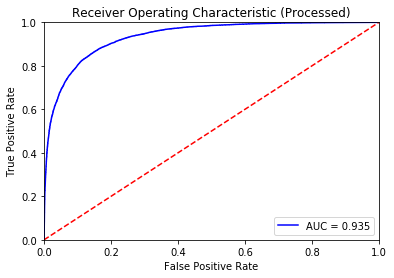

In [33]:
# Calculate AUC for processed data
auc_processed, fpr_processed, tpr_processed, threshold_processed = find_LR_perf(X_train, y_train, X_test, y_test)
print(auc_processed)

plt.title('Receiver Operating Characteristic (Processed)')
plt.plot(fpr_processed, tpr_processed, 'b', label = 'AUC = %0.3f' % auc_processed)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
# Calculate AUC for unprocessed data

df_joint_unprocessed = df_joint.copy()
df_joint_unprocessed = df_joint_unprocessed.dropna(axis=0, how='any')

X_unprocessed = df_joint_unprocessed.drop(target, 1)
y_unprocessed = df_joint_unprocessed.bike_rental_percentage

X_train_unprocessed, X_test_unprocessed, y_train, y_test = train_test_split(
    X_unprocessed, y_unprocessed, train_size=train_test_split_thresh, random_state=1)

0.752690049905496


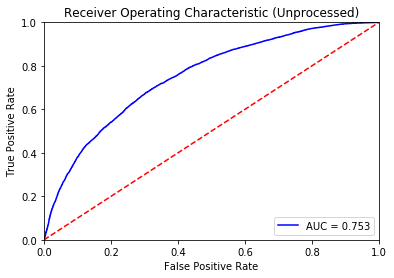

In [35]:
# Calculate AUC for processed data
auc_unprocessed, fpr_unprocessed, tpr_unprocessed, threshold_unprocessed = find_LR_perf(X_train_unprocessed, y_train, X_test_unprocessed, y_test)
print(auc_unprocessed)

plt.title('Receiver Operating Characteristic (Unprocessed)')
plt.plot(fpr_unprocessed, tpr_unprocessed, 'b', label = 'AUC = %0.3f' % auc_unprocessed)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [36]:
# Compare AUC with and without data preprocessing

print('AUC of model with data feature interation and selection: {auc}'.format(auc=auc_processed))
print('AUC of model with data without feature interation and selection: {auc}'.format(auc=auc_unprocessed))
per_improve = ((auc_processed-auc_unprocessed)/auc_unprocessed)*100
print('Model improvement of feature interation and selection: {per_improve}%'.format(per_improve = per_improve))
print('Processed time: {} minutes'.format((time.time() - start_time) / 60))

AUC of model with data feature interation and selection: 0.9353081038085084
AUC of model with data without feature interation and selection: 0.752690049905496
Model improvement of feature interation and selection: 24.262052344911552%
Processed time: 10.334298773606617 minutes
